# Setup


> Import libraries

> Import Drive




In [0]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 35.7MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
import pandas as pd
import numpy as np
import io
import os

from tqdm import tqdm

import fastai
from fastai import *
from fastai.text import * 
from functools import partial
from fastai.vision import *
from fastai.metrics import error_rate

import h5py
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from fastai.callbacks import EarlyStoppingCallback, SaveModelCallback
from fastai.metrics import error_rate

# Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials
from google.colab import drive

Google Drive

In [0]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# GoogleDrive(gauth)
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


General parameters and settings

In [0]:
input_models_folder = "/content/drive/My Drive/document-classification/models/final-models/"
output_models_folder = "/content/drive/My Drive/document-classification/models/output-late-fusion"
dataset_path = "/content/drive/My Drive/document-classification/datasets/rvl-cdip/mini-dataset-1488-288-192"

path_train_ocr = os.path.join(dataset_path, 'train_extracted.csv')
path_test_ocr = os.path.join(dataset_path, 'test_extracted.csv')
path_valid_ocr = os.path.join(dataset_path, 'valid_extracted.csv')

# Shape of the images in input to the CNN
cnn_image_shape = (224, 224)
# Number of images classes
n_classes = 16
# Batch size to be used in training
batch_size = 32

# Input Models

Load the VGG model (image classification) and the LSTM based model (text classification) trained in the previous notebooks.

## VGG Model

### Data

In [0]:
df_train = pd.read_csv(os.path.join(dataset_path, "train-labels.csv"), names=["image", "label"])
df_valid = pd.read_csv(os.path.join(dataset_path, "valid-labels.csv"), names=["image", "label"])
df_train["is_valid"] = False
df_valid["is_valid"] = True
df_joined = pd.concat([df_train, df_valid], ignore_index=True)
print(df_joined.head())
print(df_joined.tail())

data_vgg = (ImageList.from_df(df_joined, dataset_path, cols="image")#, folder=mini_dataset_path)
        .split_from_df()
        .label_from_df()
        .transform(size=cnn_image_shape, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=batch_size)
        .normalize())

                                 image  label  is_valid
0  train/0/0/0/0/94002065_94002066.tif     10     False
1         train/0/0/0/1/2074950097.tif     10     False
2      train/0/0/0/2/50284095-4103.tif      6     False
3           train/0/0/0/3/04003306.tif     10     False
4         train/0/0/0/4/2024967978.tif     11     False
                                        image  label  is_valid
1771             valid/0/2/8/3/0060077830.tif      7      True
1772             valid/0/2/8/4/2045723775.tif     15      True
1773  valid/0/2/8/5/2062426213_2062426237.tif     12      True
1774      valid/0/2/8/6/01747683_01747694.tif     13      True
1775               valid/0/2/8/7/10395005.tif      8      True


### Model

In [0]:
learn_vgg = cnn_learner(data_vgg, models.vgg16_bn, metrics=accuracy,
                    model_dir=input_models_folder)
learn_vgg.load("image-class_1488-288-192_valid-acc-67.36");
learn_vgg.model

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

Remove the final layers from the model: ***NOT HERE IN THIS FUSION***

In [0]:
#learn_vgg.model[-1] = learn_vgg.model[-1][:-3] 
#learn_vgg.model

## LSTM-based Model (ULMFiT)

### Data

In [0]:
df_trn, df_val, df_test = pd.read_csv(path_train_ocr,names=['text','label']), pd.read_csv(path_valid_ocr,names=['text','label']), pd.read_csv(path_test_ocr,names=['text','label'])
print(df_trn.shape, df_val.shape, df_test.shape)

(1488, 2) (288, 2) (192, 2)


In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "",
                                  text_cols="text", label_cols="label")
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val,
                                      text_cols="text", label_cols="label", vocab=data_lm.train_ds.vocab, bs=batch_size)

### Model

In [0]:
learn_text = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.7,
                                     model_dir=input_models_folder)
learn_text.load("text-class_1488-288-192_valid-acc-59.38")
learn_text.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(15392, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(15392, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.27999999999999997, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): 

***NOT HERE IN THIS FUSION***
Remove the final layers from the model (according to https://gist.github.com/joshfp/b62b76eae95e6863cb511997b5a63118)

In [0]:
#learn_text.model[-1].layers = learn_text.model[-1].layers[:-3] 
#learn_text.model

# Concatenated Model

Combine the two previous models into a new one. Doing this, the new model will classify using both visual and textual features.

## Data

Define a custom PyTorch Dataset to concat the two datasets (images and text).

When an element of the Dataset is requested (\_\_getitem\__ method) resize the corresponding image to the target size before returning it along with the text and the label.

N.B.: passing an ImageList could not be memory efficient (check how fastai manage the images in ImageList). Consider passing a list of paths and loading the image in \_\_getItem\_\_

In [0]:
# Per accedere ad alcune funzionalità di fastai è necessario definire cose aggiuntive
# nel Dataset
class ConcatDataset(Dataset):
    def __init__(self, x_images: ImageList, x_texts: TextList, y): 
        self.x_images = x_images
        self.x_texts = x_texts
        self.y = y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return (self.x_images[i].apply_tfms([], size=cnn_image_shape, resize_method=ResizeMethod.SQUISH),
                                      self.x_texts[i]), self.y[i]

train_ds = ConcatDataset(data_vgg.train_ds.x, data_clas.train_ds.x, data_vgg.train_ds.y)
valid_ds = ConcatDataset(data_vgg.valid_ds.x, data_clas.valid_ds.x, data_vgg.valid_ds.y)

Define a collate function to pass to the DataBunch. This function will replace the one used by the Dataloader and describe how to collate the samples taken for a batch from the ConcatDataset.

In [0]:
def my_collate(batch):
    x,y = list(zip(*batch))
    x1,x2 = list(zip(*x))
    x1 = to_data(x1)
    x1 = torch.stack(x1)
    x2, y = pad_collate(list(zip(x2, y)), pad_idx=1, pad_first=True)
    
    return (x1, x2), y

The following two cells were used in the example taken from https://gist.github.com/joshfp/b62b76eae95e6863cb511997b5a63118.

The Sampler would allow to random sort data, but their behaviour is not clear to us.
We found simpler letting the DataBunch automatic creating the DataLoaders.

Create the DataBunch from the custom datasets and the collate function.

In [0]:
data = DataBunch.create(train_ds, valid_ds, collate_fn=my_collate, path=dataset_path, bs=batch_size)

In [0]:
data.one_batch()

## Model

Define the new model taking the other two and adding linear layers at the end.

The size of the input to the first linear layer must agree with the output of the other two models.

We add two blocks of batch normalization + dropout + linear layers.

Dropout probability suggested values are 0.25 for the dropout between the input layer and the linear layer before softmax, and 0.5 for the dropout before softmax layer. In this case, the input size to the first linear layer is only 32 (16 probabilities from the text classifier + 16 probabilities from the image classifier) so set dropout probability to 0.

In [0]:
learn_vgg.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 224, 224]       1,792      False     
______________________________________________________________________
BatchNorm2d          [64, 224, 224]       128        True      
______________________________________________________________________
ReLU                 [64, 224, 224]       0          False     
______________________________________________________________________
Conv2d               [64, 224, 224]       36,928     False     
______________________________________________________________________
BatchNorm2d          [64, 224, 224]       128        True      
______________________________________________________________________
ReLU                 [64, 224, 224]       0          False     
______________________________________________________________________
MaxPool2d            [64, 112, 112]       0          False     
___________________________________________________

In [0]:
class ConcatModel(nn.Module):
    def __init__(self, mod_cnn, mod_nlp, input_dim, output_dim): 
        super().__init__()
        self.mod_cnn = mod_cnn
        self.mod_nlp = mod_nlp
        
        # Final custom part
        n_neurons = 256
        last_layers = []
        last_layers += bn_drop_lin(input_dim, n_neurons, p=0, actn=nn.ReLU(inplace=True))
        last_layers += bn_drop_lin(n_neurons, output_dim, p=0.5)
        # lst_layers = []
        # activs = [nn.ReLU(inplace=True),] * (len(layers)-2) + [None]
        # for n_in,n_out,p,actn in zip(layers[:-1], layers[1:], drops, activs):
        #     lst_layers += bn_drop_lin(n_in, n_out, p=p, actn=actn)
        self.layers = nn.Sequential(*last_layers)

    def forward(self, x_cnn, x_nlp):
        x_cnn = self.mod_cnn(x_cnn)
        # perchè [0]? Rimuovere? -> Forse perche il cat si aspetta la stessa 
        # dimensione dei tensori lungo la dim=0 e x_nlp diventa multidim?
        x_nlp = self.mod_nlp(x_nlp)[0]
        x = torch.cat([x_cnn, x_nlp], dim=1)
        return self.layers(x)    

In [0]:
input_dim = 32
output_dim = 16
model = ConcatModel(learn_vgg.model, learn_text.model, input_dim, output_dim)
model

ConcatModel(
  (mod_cnn): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): ReLU(inplace=True)
        (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (12): ReLU(inplace=True)
       

## Learner

In [0]:
print(len(learn_text.layer_groups))
print(len(learn_vgg.layer_groups))

5
3


In [0]:
learn_vgg.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [0]:
learn_vgg.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace=True)
   (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (5): ReLU(inplace=True)
   (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): ReLU(inplace=True)
   (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (12): ReLU(inplace=True)
   (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 

Define layer groups for the new model. Reuse the two other models layer groups and add a group with the new final layers.

N.B. Separate the CNN linear layers from the last convolutional section into a new group (Do it in the notebook 2)

In [0]:
loss_func = nn.CrossEntropyLoss()
# Serve per il discriminative layer training -> serve per dare learning rates diversi
# ad ogni gruppo
# Approfondire quali layer appartengono ai gruppi
layer_groups = [nn.Sequential(*flatten_model(learn_text.layer_groups[0])),
                nn.Sequential(*flatten_model(learn_text.layer_groups[1])),
                nn.Sequential(*(flatten_model(learn_text.layer_groups[2]) + 
                                flatten_model(learn_vgg.layer_groups[0]))),
                nn.Sequential(*(flatten_model(learn_text.layer_groups[3]) + 
                                flatten_model(learn_vgg.layer_groups[1]))),
                nn.Sequential(*(flatten_model(learn_text.layer_groups[4]) + 
                                flatten_model(learn_vgg.layer_groups[2]))),
                nn.Sequential(*flatten_model(model.layers))]

learn = Learner(data, model, loss_func=loss_func, metrics=accuracy, layer_groups=layer_groups,
                path=output_models_folder)

# Training

In [0]:
# Congela tutti i gruppi di layer in layer_groups tranne nell'ultimo (i fully connected)
learn.freeze()
# learn.summary() -> non funziona per via del custom dataset

Find the best learning rate studying its trend (Experimental).

This function has been taken from this post: https://forums.fast.ai/t/automated-learning-rate-suggester/44199

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


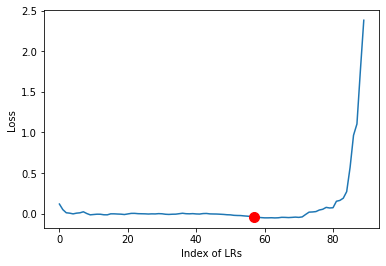

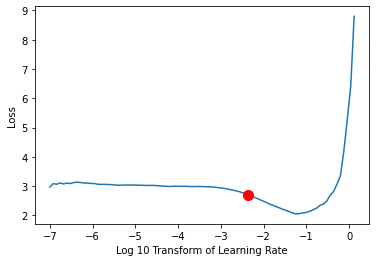

Learning rate: 0.004365158322401656


In [0]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

learning_rate = find_appropriate_lr(learn, plot=True)
print(f"Learning rate: {learning_rate}")

Train the network.

In [0]:
save_model = SaveModelCallback(learn, every="improvement", monitor="accuracy",
                               mode="max", name="best-late-fusion")
learn.fit_one_cycle(80, max_lr=learning_rate, callbacks=[save_model])
print("Training completed")

epoch,train_loss,valid_loss,accuracy,time
0,2.562870,2.268186,0.368056,02:23
1,2.041801,1.710591,0.618056,01:25
2,1.504132,1.334311,0.670139,01:25
3,1.071713,1.125241,0.715278,01:26
4,0.749341,1.016885,0.711806,01:26
5,0.550182,0.968455,0.722222,01:25
6,0.405874,0.976125,0.715278,01:25
7,0.304332,0.979401,0.732639,01:25
8,0.239205,1.001340,0.718750,01:26
9,0.202554,1.079045,0.711806,01:26


Better model found at epoch 0 with accuracy value: 0.3680555522441864.
Better model found at epoch 1 with accuracy value: 0.6180555820465088.
Better model found at epoch 2 with accuracy value: 0.6701388955116272.
Better model found at epoch 3 with accuracy value: 0.7152777910232544.
Better model found at epoch 5 with accuracy value: 0.7222222089767456.
Better model found at epoch 7 with accuracy value: 0.7326388955116272.
Better model found at epoch 38 with accuracy value: 0.7430555820465088.
Training completed
